# Question1: PCA and Frye eigenvectors

Get the days of the US Treasury yield curve data during 2021 from FRED using the code in cls4prob1.py.
Compute the covariance matrix of day-over-day arithmetic changes in yields. Compute the principal components (eigenvectors) of this covariance matrix. What is the percentage of the trace from the first 3 PC's? Graph the first 3 eigenvectors. Do they look like the Frye eigenvectors shown in class? Why or why not?

In [1]:
import qrpm_funcs as qf
import numpy as np
seriesnames=['DGS1MO','DGS3MO','DGS6MO','DGS1','DGS2', \
             'DGS3','DGS5','DGS7','DGS10','DGS20','DGS30']
maturities=qf.TenorsFromNames(seriesnames)
lastday=qf.LastYearEnd()
firstday=qf.LastYearEnd(int(lastday[:4])-1)
dates_dirty,prices_dirty=qf.GetFREDMatrix(seriesnames, \
            startdate=firstday,enddate=lastday)
#remove no-data periods
nan_list=[any(np.isnan(p)) for p in prices_dirty]
prices=[prices_dirty[i] for i in range(len(prices_dirty)) if not nan_list[i]]
dates=[dates_dirty[i] for i in range(len(dates_dirty)) if not nan_list[i]]

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
prices_array = np.array(prices)
daily_changes = np.diff(prices_array, axis=0)
cov_matrix = np.cov(daily_changes, rowvar=False)
eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)
percentage_trace = sum(eigenvalues[-3:]) / sum(eigenvalues) * 100

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [3]:
print(f"The percentage trace from the first 3 PC's is {percentage_trace}")

The percentage trace from the first 3 PC's is 94.35231626784429


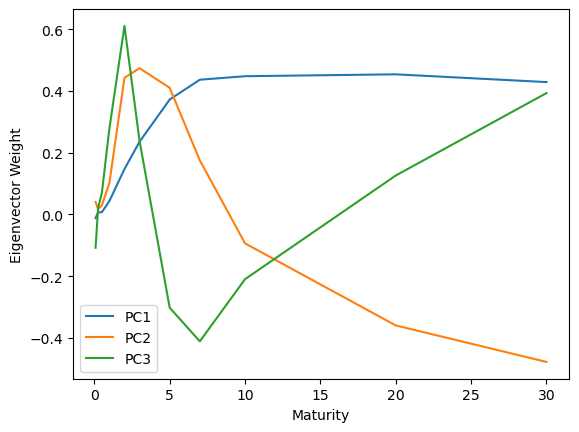

In [4]:
import matplotlib.pyplot as plt

for i in range(1, 4):
    plt.plot(maturities, eigenvectors[:, -i], label=f'PC{i}')
plt.xlabel('Maturity')
plt.ylabel('Eigenvector Weight')
plt.legend()
plt.show()

Yes, they look like the Frye eigenvectors shown in class. Althogh the years are different, the first three PC's still represent level, slope and twist.

# Question2: Nelson-Siegel curve

The last curve you retrieved in Problem 1 was the 2021 yearend US Treasury curve. Using straight-line interpolation between given maturities, generate the 360 levels of that curve for each maturity month from 1 month to 30 years. Fit the parameters of a Nelson-Siegel curve to this so that the sum of the absolute differences between each month’s straight-line curve rate and the Nelson-Siegel rate is minimized. Graph the original curve and the Nelson-Siegel curve. What does the Nelson-Siegel curve imply about the perpetual interest rate, i.e. the rate paid on infinite maturity bonds?

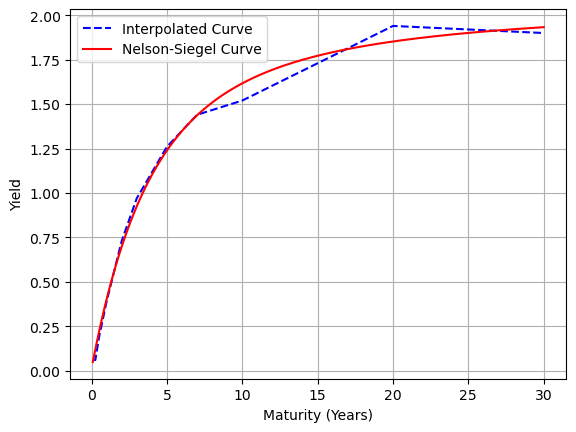

The Nelson-Siegel curve implies a perpetual interest rate of approximately 2.0942 or 209.42%.


In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# 1. Interpolation
maturities_last_day = maturities
yields_last_day = prices[-1] 

interp_maturities = np.linspace(1/12, 30, 360)
interp_yields = np.interp(interp_maturities, maturities_last_day, yields_last_day)

# 2. Nelson-Siegel Function and Optimization
def nelson_siegel(t, beta0, beta1, beta2, tau):
    return beta0 + beta1 * (1 - np.exp(-t/tau)) / (t/tau) + beta2 * ((1 - np.exp(-t/tau)) / (t/tau) - np.exp(-t/tau))

def objective(params, t, y):
    return np.sum(np.abs(y - nelson_siegel(t, *params)))

initial_guess = [0.03, -0.02, 0.02, 1.5] 
result = minimize(objective, initial_guess, args=(interp_maturities, interp_yields))
beta0, beta1, beta2, tau = result.x
ns_yields = nelson_siegel(interp_maturities, beta0, beta1, beta2, tau)

plt.plot(interp_maturities, interp_yields, label='Interpolated Curve', color='blue', linestyle='--')
plt.plot(interp_maturities, ns_yields, label='Nelson-Siegel Curve', color='red')
plt.xlabel('Maturity (Years)')
plt.ylabel('Yield')
plt.legend()
plt.grid(True)
plt.show()

print(f"The Nelson-Siegel curve implies a perpetual interest rate of approximately {beta0:.4f} or {beta0*100:.2f}%.")


β0 would be the implied perpetual interest rate for the US Treasury curve.

# Question3

Use chap4.py to get the 3-currency data used in Chapter 4 of QRPM from the beginning of 1971 to the end of 2021. Take the year 2021 out of this data (the holdout set; the data before that is the learning set. Compute the learning set's equality-constrained efficient frontier as in the formulas for its means and standard deviation.

In [6]:
#chap4.py
import pandas as pd
import qrpm_funcs as qf
#Get 3 currencies until the end of
#previous year. Form sample covariance matrix
#and do simple efficient frontier calculations

lastday=qf.LastYearEnd()
#Swiss franc, pound sterling, Japanese Yen
seriesnames=['DEXSZUS','DEXUSUK','DEXJPUS']
cdates,ratematrix=qf.GetFREDMatrix(seriesnames,enddate=lastday)
multipliers=[-1,1,-1]

lgdates,difflgs=qf.levels_to_log_returns(cdates,ratematrix,multipliers)

### Use the formulas for the efficient frontier

The formulas for the equality-constrained efficient frontier are:

$$
\mu = \frac{\sum_{i} w_i \mu_i}{\sum_{i} w_i}
$$
Where:
- $ \mu $ = Portfolio return
- $ w_i $ = Weight of asset i in the portfolio (equal weights for all assets in this case)
- $ \mu_i $ = Return of asset i

$$
\sigma = \sqrt{w^T \Sigma w}
$$
Where:
- $ \sigma $ = Portfolio standard deviation
- $ w $ = Vector of portfolio weights
- $ \Sigma $ = Covariance matrix



In [7]:
import pandas as pd
import qrpm_funcs as qf
import numpy as np

# Convert the list of dates to a pandas datetime format
lgdates_dt = pd.to_datetime(lgdates)

# Convert the log returns to a DataFrame for easier slicing
df = pd.DataFrame(difflgs, index=lgdates_dt)

# Extract the data for the year 2021
holdout_data = df[df.index.year == 2021]
learning_data = df[df.index.year < 2021]

# Calculate mean returns and the sample covariance matrix for the data up to 2020
mean_returns = learning_data.mean()
cov_matrix = learning_data.cov()

# Calculate the equality-constrained efficient frontier
n_assets = len(seriesnames)
equal_weights = np.repeat(1/n_assets, n_assets)

portfolio_return = np.dot(equal_weights, mean_returns)
portfolio_std_dev = np.sqrt(np.dot(equal_weights.T, np.dot(cov_matrix, equal_weights)))

print("Equality-Constrained Portfolio Return:", portfolio_return)
print("Equality-Constrained Portfolio Standard Deviation:", portfolio_std_dev)


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Equality-Constrained Portfolio Return: 5.929673476567304e-05
Equality-Constrained Portfolio Standard Deviation: 0.005182871343279609


In [8]:
import numpy as np

def compute_optimal_weights(cov_matrix, mean_returns, lambda_value):
    """Compute the optimal portfolio weights."""
    inv_cov = np.linalg.inv(cov_matrix)
    numerator = np.dot(inv_cov, mean_returns)
    denominator = lambda_value + np.dot(np.ones_like(mean_returns), numerator)
    return numerator / denominator

lambdas = [0.01 * i for i in range(11)]
learning_variances = []
holdout_variances = []

# Compute portfolio weights for each lambda and calculate variance in both sets
for lambda_value in lambdas:
    weights = compute_optimal_weights(cov_matrix, mean_returns, lambda_value)
    
    # Portfolio variance in learning set
    learning_variance = np.dot(weights.T, np.dot(cov_matrix, weights))
    learning_variances.append(learning_variance)
    
    # Portfolio variance in holdout set
    holdout_cov_matrix = holdout_data.cov()
    holdout_variance = np.dot(weights.T, np.dot(holdout_cov_matrix, weights))
    holdout_variances.append(holdout_variance)

# Check order of variances
learning_order = np.argsort(learning_variances)
holdout_order = np.argsort(holdout_variances)

print("Learning Set Variances Order:", learning_order)
print("Holdout Set Variances Order:", holdout_order)

# Check if the order of variances is the same in both sets
if np.array_equal(learning_order, holdout_order):
    print("The order of variances is the SAME in both sets.")
else:
    print("The order of variances is DIFFERENT in both sets.")

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
